In [8]:
# Limpiamos todas las variables
%reset -f


# Integrantes
|N° SIU| NOMBRE APELLIDO--------------| CORREO---------------------|
|-----|-------------------------------|----------------------------|
|a1904|	Marck Anthony Murillo Ronquillo| murillo.ronq.50c2@gmail.com|
|a1906|	Yandri Jair	Uchuari Gallardo| yandriuchuari@gmail.com|
|a1823|	Luis Alberto Santamaria Jimenez| santamaria.luigi@gmail.com|

# **TACO Trash -	[taco-trash-dataset](https://www.kaggle.com/datasets/kneroma/tacotrashdataset)**

### Tipo de problema : Detección
- objetivo detección de residuos: Utilizar imágenes para identificar la presencia de residuos. Este modelo puede ser útil para planificar limpiar y preservar estos espacios.​
- Entrenar un modelo para identificar la presencia de residuos plásticos en imágenes.

### Las diapositivas y el código deben contener:
- Descripción del problema que hay detrás del conjunto de datos.
- Análisis exploratorio del conjunto de datos.
- Tarea de visión por computadora a resolver y métricas a utilizar para evaluarla.
- Uso de Data Augmentation. Porque sí o porque no. Cuales se utilizaron y sus configuraciones.
- Arquitecturas de modelos a entrenar (al menos 2).
- Uso de Transfer Learning. Porque sí o porque no. En caso de utilizarlo a partir de que pesos de realizó.
- Entrenamientos realizados (al menos 4). Hiperparametros utilizados en cada uno.
- Gráficas de resultados y sus comparaciones.
- Conclusiones.




## EDA (Análisis exploratorio del dataset)

In [9]:
## descarga del dataset desde kagglehub
## Instalamos librerias 
#try:
#    import kagglehub
#    #import gdown
#    print("Todas las librerías ya están instaladas")
#except ImportError:
#    !pip install kagglehub
#    import kagglehub
#    #!pip install --upgrade --no-cache-dir gdown
#    print("Instalación completada")
##import kagglehub
#
## Download latest version
#path = kagglehub.dataset_download("kneroma/tacotrashdataset", force_download=True)
#
#print("Path to dataset files:", path)


In [10]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import numpy as np
import os
from collections import Counter
import seaborn as sns


In [11]:
# Descarga del dataSet desde Repo en el Driver 
import os
import zipfile
import gdown

def descargar_y_preparar_dataset_taco(url_id_drive,carpeta_destino): 
    """
    Descarga un archivo ZIP de Google Drive
    """
    # 1. Verificar si la carpeta descomprimida ya existe
    if os.path.exists(carpeta_destino) and os.path.isdir(carpeta_destino) and os.listdir(carpeta_destino):
        print(f"El Dataset  '{carpeta_destino}' ya existe no se requiere descargar el miso .")
        return

    # 2. Descargar el archivo ZIP desde Google Drive
    try:
        ruta_zip_descargado = gdown.download(f"https://drive.google.com/uc?id={url_id_drive}", fuzzy=True)
        print(f"Descarga completada. Archivo guardado como: '{ruta_zip_descargado}'")

    except Exception as e:
        print(f"Error durante la descarga del archivo ZIP: {e}")
        return

    # 3. Descomprimir el archivo .zip
    try:
        with zipfile.ZipFile(ruta_zip_descargado, 'r') as zip_ref:
            zip_ref.extractall()
            print(f" Fin de la Descompresión  '{ruta_zip_descargado}")
    except Exception as e:
        print(f"Error durante la descompresión del archivo ZIP: {e}")
        return

    # 4. Borrar el archivo .zip después de la descompresión
    try:
        os.remove(ruta_zip_descargado)
        print(f"Archivo ZIP eliminado correctamente.... {ruta_zip_descargado}")
    except Exception as e:
        print(f"Error al intentar eliminar el archivo ZIP: {e}")


# --- Uso del código ---
# https://drive.google.com/file/d/1kFiYY3urHldf8E10mubslpoK1my61B0V/view?usp=drive_link
url_del_dataset = "1kFiYY3urHldf8E10mubslpoK1my61B0V"
carpeta_destino = "tacotrashdataset" # La carpeta donde se descomprimirá

descargar_y_preparar_dataset_taco(url_del_dataset, carpeta_destino)


El Dataset  'tacotrashdataset' ya existe no se requiere descargar el miso .


### **Verificación de contenido de archivos**

Como podemos observar a continuación en el dataset no tenemos una división en la estructura de las clases (etiqueta) y tenemos un total de 1500 archivos de imagen  .jpg  

In [12]:
# verificación de contenido de archivos 
import os
from collections import defaultdict 

def print_dir_tree(start_path, indent='  '):
    """
    Muestra el árbol de directorios 
    """
    print(f"Directorio: {start_path}")
    # Diccionario para contar extensiones
    extension_counts = defaultdict(int)
    base_level = start_path.rstrip(os.sep).count(os.sep)

    for root, dirs, files in os.walk(start_path):
        level = root.count(os.sep) - base_level
        subindent = indent * level
        folder_name = os.path.basename(root) + os.sep # Aseguramos que termine con el separador de directorio
        print('{}|-- {}'.format(subindent, folder_name))

        # Contar archivos y sus extensiones
        for file in files:
            _, ext = os.path.splitext(file)
            ext = ext.lower() if ext else '[sin extensión]'
            extension_counts[ext] += 1

    # Mostrar resumen de extensiones al final
    print("\nResumen de archivos por extensión:")
    for ext, count in sorted(extension_counts.items()):
        print(f"{ext or 'Sin extensión'} : {count}")

print_dir_tree('./tacotrashdataset')

Directorio: ./tacotrashdataset
|-- tacotrashdataset\
  |-- data\
    |-- batch_1\
    |-- batch_10\
    |-- batch_11\
    |-- batch_12\
    |-- batch_13\
    |-- batch_14\
    |-- batch_15\
    |-- batch_2\
    |-- batch_3\
    |-- batch_4\
    |-- batch_5\
    |-- batch_6\
    |-- batch_7\
    |-- batch_8\
    |-- batch_9\
  |-- versions\
    |-- 3\

Resumen de archivos por extensión:
.bin : 1
.complete : 1
.csv : 1
.jpg : 1500
.json : 1
.txt : 1
.zip : 1


### **Visualización de las imágenes**. 

Como podemos observar a continuación, se seleccionaron aleatoriamente seis imágenes para una inspección inicial de su contenido. El conjunto de datos combina imágenes de residuos de distintos tipos (plástico, metal, papel); sin embargo, notamos que algunas imágenes de residuos se mezclan con elementos no relacionados.

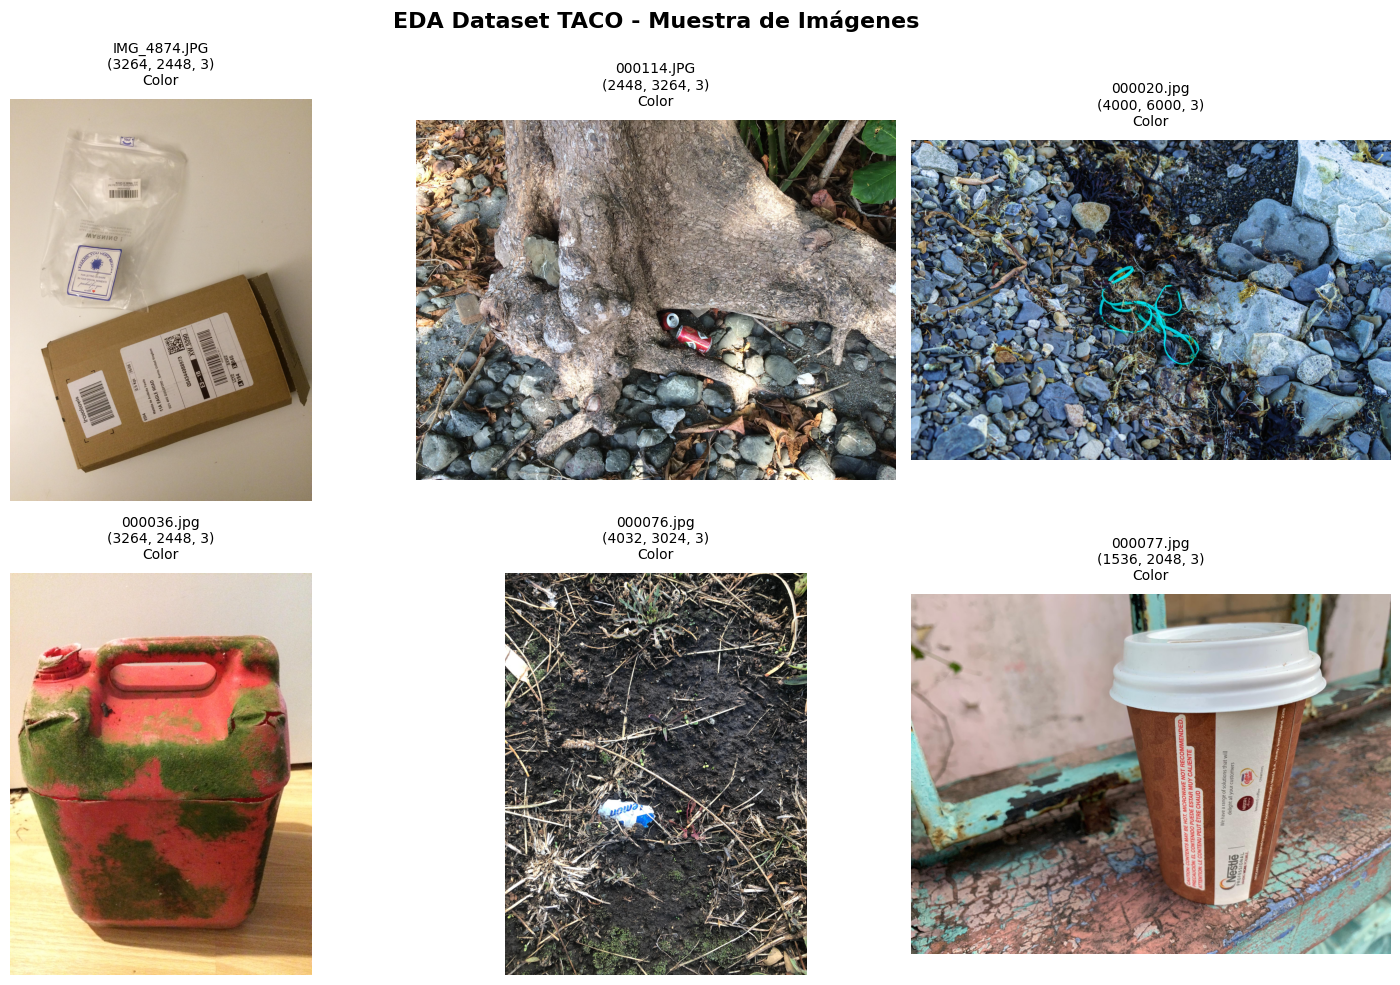

In [13]:
#import matplotlib.pyplot as plt
#import cv2
#from pathlib import Path

# Lista de archivos de imágenes
dataset_img ='./tacotrashdataset/data/'
imagen_files = [
    dataset_img+"batch_3/IMG_4874.JPG",
    dataset_img+"batch_7/000114.JPG",
    dataset_img+"batch_11/000020.jpg",
    dataset_img+"batch_11/000036.jpg",
    dataset_img+"batch_14/000076.jpg",
    dataset_img+"batch_15/000077.jpg"
]

def analizar_imagen(ruta_imagen):
    """
    Analiza una imagen y devuelve información básica
    """
    try:
        # Cargar imagen con OpenCV (BGR)
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            return None, f"Error: No se pudo cargar {ruta_imagen}"
        
        # Convertir de BGR a RGB para matplotlib
        imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        
        # Obtener información básica
        nombre_archivo = Path(ruta_imagen).name
        dimensiones = imagen_rgb.shape
        
        # Verificar si es realmente escala de grises
        if len(imagen_rgb.shape) == 3:
            es_gris_real = (imagen_rgb[:,:,0] == imagen_rgb[:,:,1]).all() and \
                          (imagen_rgb[:,:,1] == imagen_rgb[:,:,2]).all()
        else:
            es_gris_real = True
        
        tipo_imagen = "Gris" if es_gris_real else "Color"
        
        # Crear título con información
        titulo = f"{nombre_archivo}\n{dimensiones}\n{tipo_imagen}"
        
        return imagen_rgb, titulo
        
    except Exception as e:
        return None, f"Error procesando {ruta_imagen}: {str(e)}"

def mostrar_dataset_imagenes():
    """
    Muestra las 6 imágenes del dataset en un grid 2x3
    """
    # Configurar el lienzo
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('EDA Dataset TACO - Muestra de Imágenes', fontsize=16, fontweight='bold')
    
    # Aplanar axes para fácil iteración
    axes = axes.flatten()
    
    for i, ruta_imagen in enumerate(imagen_files):
        imagen, titulo = analizar_imagen(ruta_imagen)
        
        if imagen is not None:
            # Mostrar imagen
            axes[i].imshow(imagen)
            axes[i].set_title(titulo, fontsize=10, pad=10)
            axes[i].axis('off')
        else:
            # Mostrar mensaje de error
            axes[i].text(0.5, 0.5, titulo, ha='center', va='center', 
                        transform=axes[i].transAxes, fontsize=10, color='red')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()



mostrar_dataset_imagenes()

### **Gráficas representativas del dataSet taco-trash**

#### Cantidad de Imágenes. 
El dataset se compone de un total de 1500 imágenes en formato .jpg, dichas imágenes  están organizadas en quince directorios desde batch_1 hasta batch_15, Es importante destacar que, al observar esta estructura, los directorios por lotes no guardan una relación directa con las clases (etiquetas) de los objetos o tipos de residuos en las imágenes.

 _Esto implica que la información de las clases debe obtenerse de otra fuente (como metadatos, un archivo de anotaciones, o la estructura de directorios que uses para las clases finales, como "plástico", "metal", etc._


#### Distribución Color vs Gris 

- **Imágenes a Color vs. Escala de Grises (3 canales)**: Se llevó a cabo una contabilización para diferenciar las imágenes a color (típicamente RGB con 3 canales) de aquellas que, aunque siendo en escala de grises, pudieran estar representadas con 3 canales (lo cual a veces ocurre cuando se convierte una imagen a color a escala de grises manteniendo la estructura de 3 canales

- **Imágenes a Color vs. Escala de Grises (1 canal)**: Adicionalmente, se contabilizaron las imágenes a color frente a las imágenes en escala de gris con un único canal 

En ambos análisis, los resultados muestran que la totalidad de las imágenes del dataset esta a color

### Relación de Aspecto (Ancho y Alto)
Las gráficas muestran la distribución de los valores de alto y ancho de las imágenes indicando una amplia variabilidad en las dimensiones. Esta diversidad en las resoluciones y proporciones de las imágenes es una característica notable del dataset. 



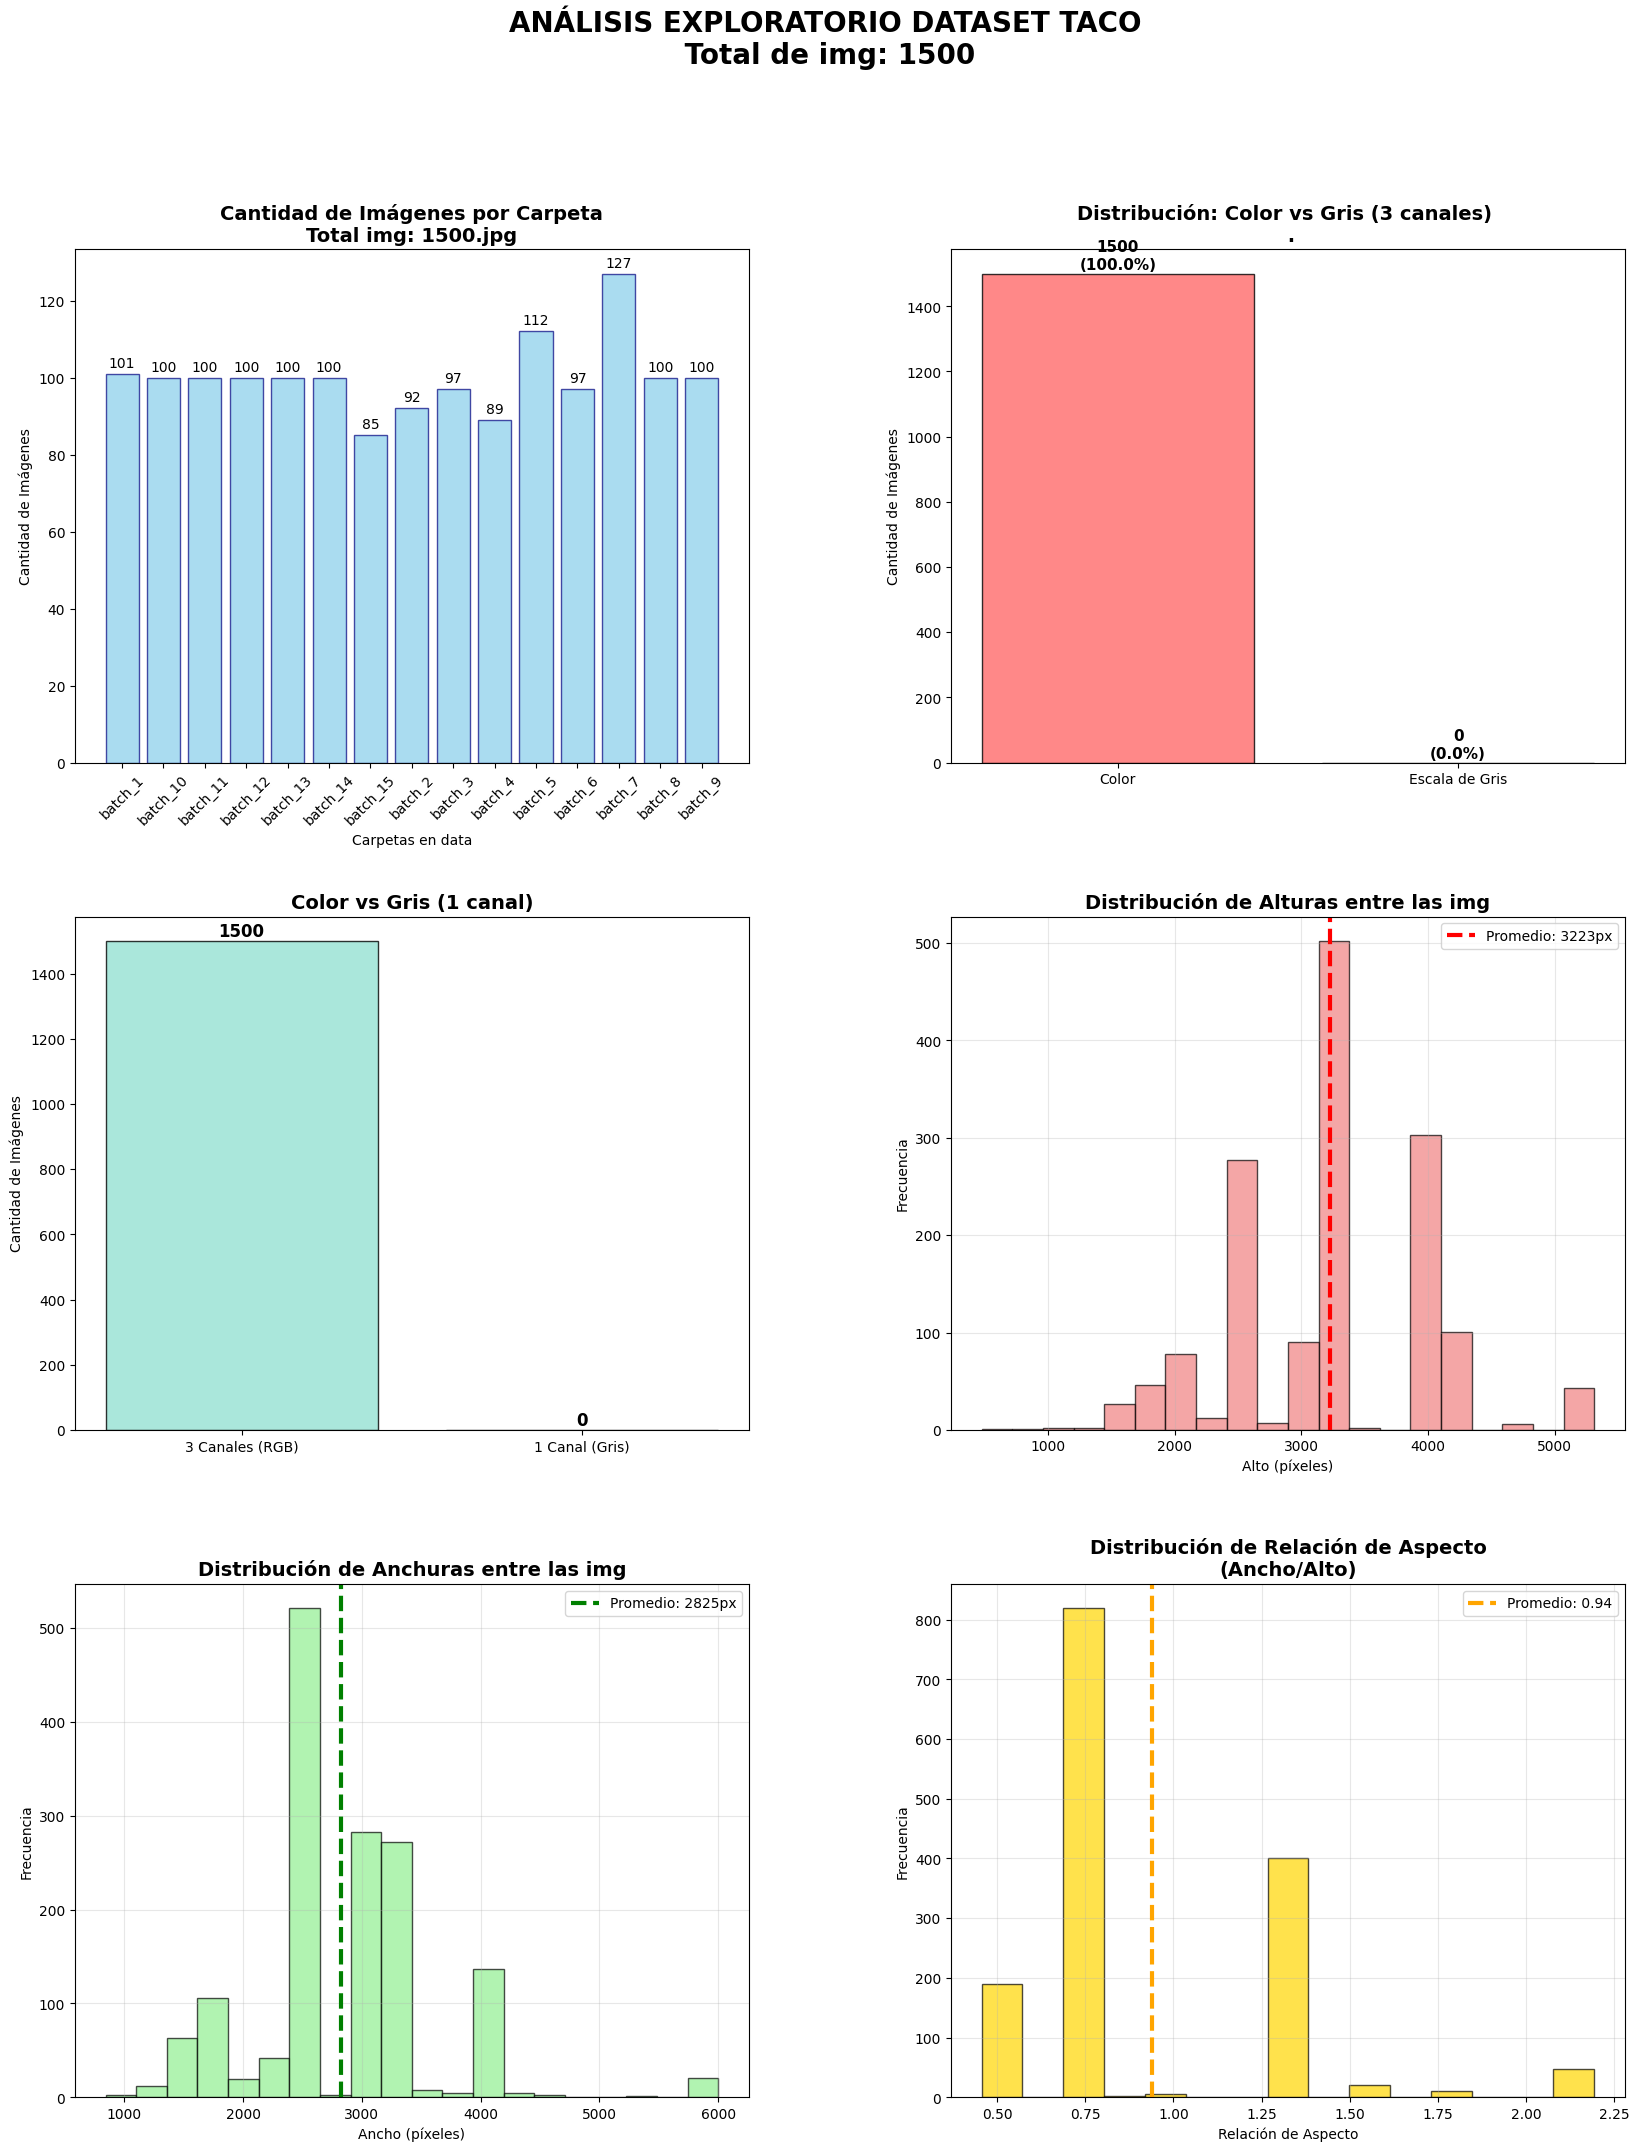

In [14]:
#import matplotlib.pyplot as plt
#import cv2
#import numpy as np
#import os
#from pathlib import Path
#from collections import Counter
#import seaborn as sns

# Configuración base del dataset
dataset_img = './tacotrashdataset/data/'

def explorar_dataset_completo():
    """
    Explora todo el dataset y recopila información para análisis
    """
    # Variables para almacenar información
    imagenes_por_carpeta = {}
    total_imagenes = 0
    imagenes_color = 0
    imagenes_gris_real = 0
    imagenes_3_canales = 0
    imagenes_1_canal = 0
    dimensiones_alto = []
    dimensiones_ancho = []
    relaciones_aspecto = []
    
    # Explorar todas las carpetas batch
    for carpeta in os.listdir(dataset_img):
        carpeta_path = os.path.join(dataset_img, carpeta)
        
        if os.path.isdir(carpeta_path) and carpeta.startswith('batch'):
            imagenes_en_carpeta = 0
            
            # Contar archivos .jpg en cada carpeta
            for archivo in os.listdir(carpeta_path):
                if archivo.lower().endswith(('.jpg', '.jpeg')):
                    archivo_path = os.path.join(carpeta_path, archivo)
                    
                    try:
                        # Cargar imagen
                        imagen = cv2.imread(archivo_path)
                        
                        if imagen is not None:
                            imagenes_en_carpeta += 1
                            total_imagenes += 1
                            
                            # Convertir a RGB
                            imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
                            
                            # Analizar canales
                            if len(imagen_rgb.shape) == 3:
                                imagenes_3_canales += 1
                                # Verificar si es realmente color o gris
                                es_gris_real = (imagen_rgb[:,:,0] == imagen_rgb[:,:,1]).all() and \
                                              (imagen_rgb[:,:,1] == imagen_rgb[:,:,2]).all()
                                if es_gris_real:
                                    imagenes_gris_real += 1
                                else:
                                    imagenes_color += 1
                            else:
                                imagenes_1_canal += 1
                                imagenes_gris_real += 1
                            
                            # Dimensiones
                            alto, ancho = imagen_rgb.shape[:2]
                            dimensiones_alto.append(alto)
                            dimensiones_ancho.append(ancho)
                            
                            # Relación de aspecto
                            relacion = ancho / alto
                            relaciones_aspecto.append(relacion)
                            
                    except Exception as e:
                        print(f"Error procesando {archivo_path}: {e}")
            
            if imagenes_en_carpeta > 0:
                imagenes_por_carpeta[carpeta] = imagenes_en_carpeta
    
    return {
        'imagenes_por_carpeta': imagenes_por_carpeta,
        'total_imagenes': total_imagenes,
        'imagenes_color': imagenes_color,
        'imagenes_gris_real': imagenes_gris_real,
        'imagenes_3_canales': imagenes_3_canales,
        'imagenes_1_canal': imagenes_1_canal,
        'dimensiones_alto': dimensiones_alto,
        'dimensiones_ancho': dimensiones_ancho,
        'relaciones_aspecto': relaciones_aspecto
    }

def crear_graficas_eda(datos):
    """
    Crea todas las gráficas del EDA en un solo lienzo
    """
    # Configurar el lienzo con subplots
    fig = plt.figure(figsize=(20, 24))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Título principal
    fig.suptitle(f'ANÁLISIS EXPLORATORIO DATASET TACO\n Total de img: {datos["total_imagenes"]}', fontsize=20, fontweight='bold', y=0.98)
    
    # 1. Gráfica de barras: Imágenes por carpeta
    ax1 = fig.add_subplot(gs[0, 0])
    carpetas = list(datos['imagenes_por_carpeta'].keys())
    cantidades = list(datos['imagenes_por_carpeta'].values())
    
    bars1 = ax1.bar(carpetas, cantidades, color='skyblue', edgecolor='navy', alpha=0.7)
    ax1.set_title(f'Cantidad de Imágenes por Carpeta\nTotal img: {datos["total_imagenes"]}.jpg', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Carpetas en data')
    ax1.set_ylabel('Cantidad de Imágenes')
    ax1.tick_params(axis='x', rotation=45)
    
    # Añadir valores en las barras
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    # 2. Gráfica de barras: Color vs Gris 3 channel 
    ax2 = fig.add_subplot(gs[0, 1])
    tipos = ['Color', 'Escala de Gris']
    cantidades_tipo = [datos['imagenes_color'], datos['imagenes_gris_real']]
    colors2 = ['#FF6B6B', '#4ECDC4']
    
    bars2 = ax2.bar(tipos, cantidades_tipo, color=colors2, edgecolor='black', alpha=0.8)
    ax2.set_title(f'Distribución: Color vs Gris (3 canales) \n .', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Cantidad de Imágenes')
    
    # Añadir porcentajes
    total = sum(cantidades_tipo)
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        porcentaje = (height/total)*100
        ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(height)}\n({porcentaje:.1f}%)', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    # 3. Gráfica de barras: 3 canales vs 1 canal
    ax3 = fig.add_subplot(gs[1, 0])
    canales = ['3 Canales (RGB)', '1 Canal (Gris)']
    cantidades_canales = [datos['imagenes_3_canales'], datos['imagenes_1_canal']]
    colors3 = ['#95E1D3', '#F38BA8']
    
    bars3 = ax3.bar(canales, cantidades_canales, color=colors3, edgecolor='black', alpha=0.8)
    ax3.set_title('Color vs Gris (1 canal)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Cantidad de Imágenes')
    
    # Añadir valores
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # 4. Histograma: Distribución de alturas con promedio
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.hist(datos['dimensiones_alto'], bins=20, color='lightcoral', alpha=0.7, edgecolor='black')
    promedio_alto = np.mean(datos['dimensiones_alto'])
    ax4.axvline(promedio_alto, color='red', linestyle='--', linewidth=3, 
                label=f'Promedio: {promedio_alto:.0f}px')
    ax4.set_title('Distribución de Alturas entre las img', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Alto (píxeles)')
    ax4.set_ylabel('Frecuencia')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Histograma: Distribución de anchuras con promedio
    ax5 = fig.add_subplot(gs[2, 0])
    ax5.hist(datos['dimensiones_ancho'], bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
    promedio_ancho = np.mean(datos['dimensiones_ancho'])
    ax5.axvline(promedio_ancho, color='green', linestyle='--', linewidth=3,
                label=f'Promedio: {promedio_ancho:.0f}px')
    ax5.set_title('Distribución de Anchuras entre las img', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Ancho (píxeles)')
    ax5.set_ylabel('Frecuencia')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Gráfica adicional: Relación de aspecto
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.hist(datos['relaciones_aspecto'], bins=15, color='gold', alpha=0.7, edgecolor='black')
    promedio_relacion = np.mean(datos['relaciones_aspecto'])
    ax6.axvline(promedio_relacion, color='orange', linestyle='--', linewidth=3,
                label=f'Promedio: {promedio_relacion:.2f}')
    ax6.set_title('Distribución de Relación de Aspecto\n(Ancho/Alto)', 
                  fontsize=14, fontweight='bold')
    ax6.set_xlabel('Relación de Aspecto')
    ax6.set_ylabel('Frecuencia')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    

    #plt.tight_layout()
    plt.show()



## Ejecutar análisis completo
#if __name__ == "__main__":
#    # Explorar dataset para la gráfica 
#    datos_dataset = explorar_dataset_completo()
#
#    # Crear gráficas
#    crear_graficas_eda(datos_dataset)

# Explorar dataset para la gráfica 
datos_dataset = explorar_dataset_completo()
# Crear gráficas
crear_graficas_eda(datos_dataset)